In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import pandas as pd

In [3]:
image_path = fr"C:\Users\surri\PycharmProjects\ML_Assignment2\image.jpg" 
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load the image

In [4]:
image.shape

(480, 640)

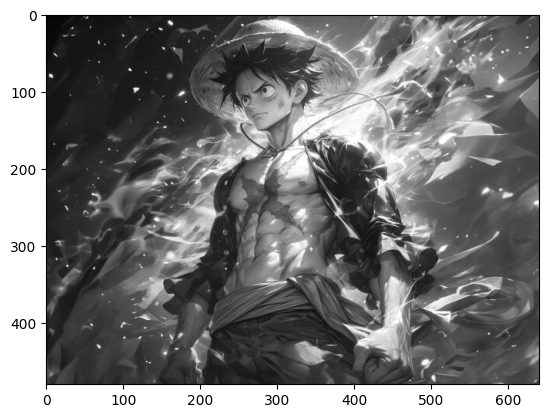

In [5]:
plt.imshow(image,cmap='gray')

In [5]:
image = cv2.resize(image,(300,300))

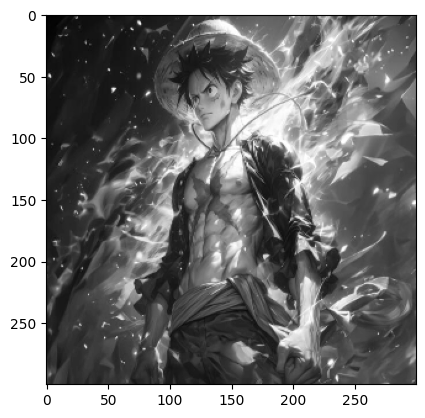

In [7]:
plt.imshow(image,cmap='gray')

In [6]:
def mask_image(img, prop):
    img = torch.from_numpy(img).float()
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

In [22]:
masked_img = mask_image(image, 0.2)

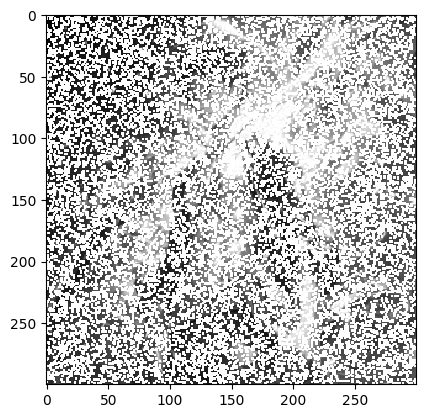

In [35]:
plt.imshow(masked_img[0], cmap='gray')

In [36]:
def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = torch.optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [50]:
W, H, loss = factorize(masked_img[0], 175, device=device)

In [51]:
loss

tensor(93.7122, device='cuda:0', grad_fn=<CopyBackwards>)

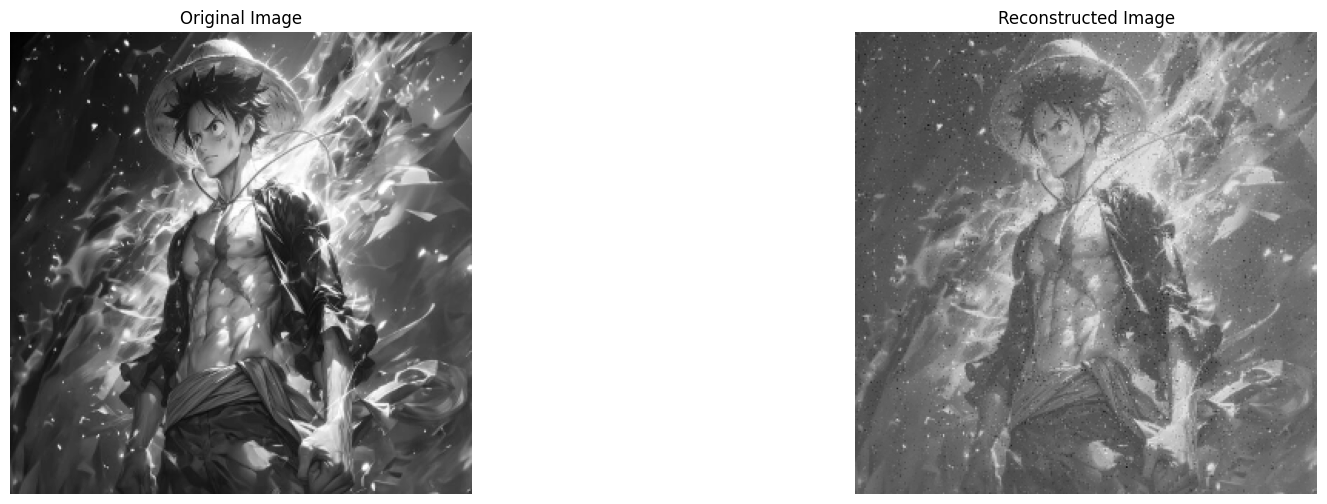

In [52]:
W, H, loss = factorize(masked_img[0],150, device=device)
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(image,cmap = "gray")
plt.title("Original Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow((W@H).cpu().detach().numpy(),cmap = "gray")
plt.title(f"Reconstructed Image")
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())
plt.axis("off")
plt.show()

In [53]:
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())

In [54]:
print(f" RMSE = {rmse.cpu().detach().numpy()}, PSNR = {psnr.cpu().detach().numpy()}")

 RMSE = 18.60379409790039, PSNR = -1.3266284465789795


### Part 2

In [39]:
x, y = (100,100)
patch_size = 30
patch = image[y:y+patch_size, x:x+patch_size]

In [40]:
img = torch.from_numpy(image).float()
img[y:y+patch_size, x:x+patch_size] = float("nan")

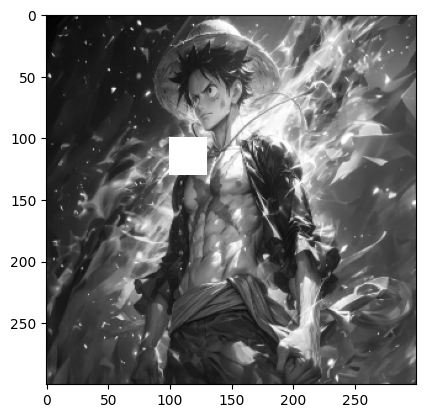

In [41]:
plt.imshow(img,cmap='gray')

In [19]:
W, H, loss = factorize(img,100, device=device)

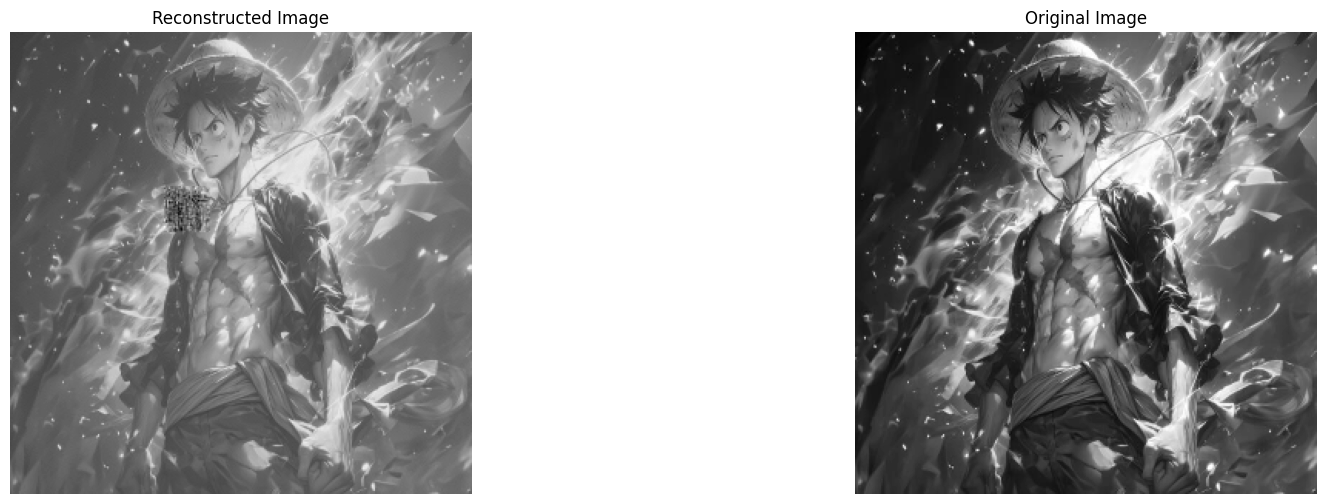

In [20]:
plt.figure(figsize=(20, 6))
plt.subplot(1,2,1)
plt.imshow(torch.mm(W,H).cpu().detach().numpy(),cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [21]:
rmse = torch.sqrt(loss).mean()
psnr = 10 * torch.log10(255.0 / loss.mean())
print(f" RMSE = {rmse.cpu().detach().numpy()}, PSNR = {psnr.cpu().detach().numpy()}")

 RMSE = 19.895048141479492, PSNR = -1.9094980955123901


**Using RFF and Linear Regression**

In [42]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import Ridge

In [43]:
height, width = img.shape
x_coords, y_coords = np.meshgrid(np.arange(width), np.arange(height))
coordinates = np.stack([x_coords.ravel(), y_coords.ravel()], axis=-1)

# 2. Mask the known and missing pixels
mask_known = ~torch.isnan(img)  # True where pixel is known
mask_missing = torch.isnan(img)  # True where pixel is NaN

# Get the known pixel coordinates and their corresponding values
known_coords = coordinates[mask_known.ravel()]  # Known pixel coordinates
known_values = img[mask_known]        # Known pixel values

# 3. Generate Random Fourier Features to approximate RBF kernel
rbf_feature = RBFSampler(gamma=1.0, n_components=40000, random_state=42)

# Transform the known pixel coordinates into RFF space
X_features_known = rbf_feature.fit_transform(known_coords)

# 4. Train Ridge Regression on the known pixel values
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_features_known, known_values)

# 5. Predict missing pixel values
missing_coords = coordinates[mask_missing.ravel()]  # Missing pixel coordinates
X_features_missing = rbf_feature.transform(missing_coords)  # RFF for missing pixels
predicted_values = ridge_regressor.predict(X_features_missing)  # Predicted missing values

# 6. Reconstruct the original image by filling in the missing values
reconstructed_image = np.copy(img)
reconstructed_image[mask_missing] = predicted_values

In [ ]:
ridge_regressor = Ridge(alpha=1.0)
ridge_regressor.fit(X_features_known, known_values)

# 5. Predict missing pixel values
missing_coords = coordinates[mask_missing.ravel()]  # Missing pixel coordinates
X_features_missing = rbf_feature.transform(missing_coords)  # RFF for missing pixels
predicted_values = ridge_regressor.predict(X_features_missing)  # Predicted missing values

# 6. Reconstruct the original image by filling in the missing values
reconstructed_image = np.copy(img)
reconstructed_image[mask_missing] = predicted_values

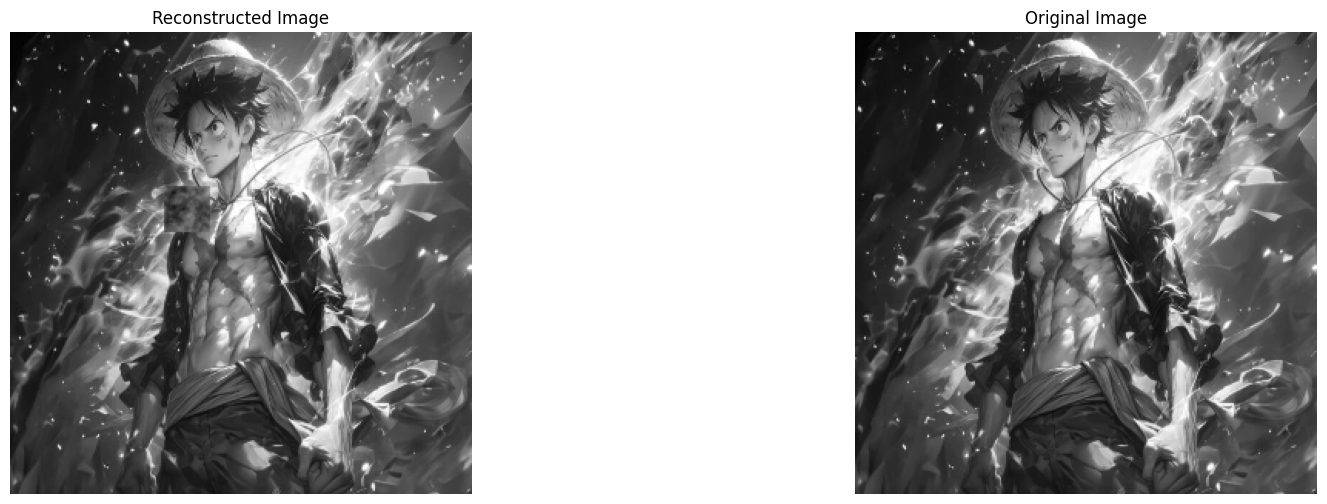

In [45]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(reconstructed_image,cmap='gray')
plt.title("Reconstructed Image")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(image,cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

In [47]:
import cv2
import numpy as np

def calculate_rmse(image1, image2):
    # Compute the RMSE
    mse = np.mean((image1 - image2) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_psnr(image1, image2):
    # Compute RMSE
    rmse = calculate_rmse(image1, image2)
    if rmse == 0:
        return float('inf')  # No noise
    
    # Compute PSNR
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / rmse)
    return psnr

# Load images
image1 = reconstructed_image.astype(np.float32)
image2 = image.astype(np.float32)

# Calculate RMSE and PSNR
rmse = calculate_rmse(image1, image2)
psnr = calculate_psnr(image1, image2)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")


RMSE: 9.534133911132812
PSNR: 28.545178658835514
